<a href="https://colab.research.google.com/github/AmirMohamadBabaee/KAN-vs-MLP/blob/main/IPL_KAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kolmogorov-Arnold Network (KAN)
**Introduction to KAN**

The Kolmogorov-Arnold Network (KAN) represents a significant advancement in the field of artificial intelligence, particularly in the domain of neural network architectures. Developed by researchers at MIT, KAN is inspired by the Kolmogorov-Arnold representation theorem, which provides a theoretical foundation for understanding how complex functions can be decomposed into simpler ones.

**Novelty of KAN**

The novelty of KAN lies in its ability to efficiently approximate any continuous function with a high degree of accuracy using a neural network structure that integrates these simpler functional components. This capability is pivotal because it addresses a fundamental challenge in neural network theory—the approximation of highly complex and nonlinear functions with minimal computational overhead. Unlike traditional neural networks that often require deep or very large architectures to approximate complex functions, KAN achieves this with a more compact and theoretically grounded framework. This makes KAN not only a powerful tool for modeling and prediction but also enhances our understanding of the underlying mechanisms of neural computation and function approximation in AI.
$$
f(x) = \sum_{q=1}^{2n+1} \Phi_q \left( \sum_{p=1}^{n} \phi_{q,p}(x_p) \right)
$$

## Import Libraries

In [ ]:
!pip install pykan


import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from kan import KAN, create_dataset

## Create Sample Dataset
### Dataset Creation

In the context of the dataset creation, we use a custom function $f$ to generate the target values based on the input variables $v1$ and $v2$. The function is defined as follows:

$$
f(x) = \frac{v1 + v2}{1 + v1 \cdot v2}
$$

The function $f$ computes the output by summing $v1$ and $v2$ and then dividing by $1$ plus the product of $v1$ and $v2$. This formula effectively balances the contributions of both variables through a non-linear interaction, which could represent a real-world relationship between two factors where their combined effect is moderated by their product.

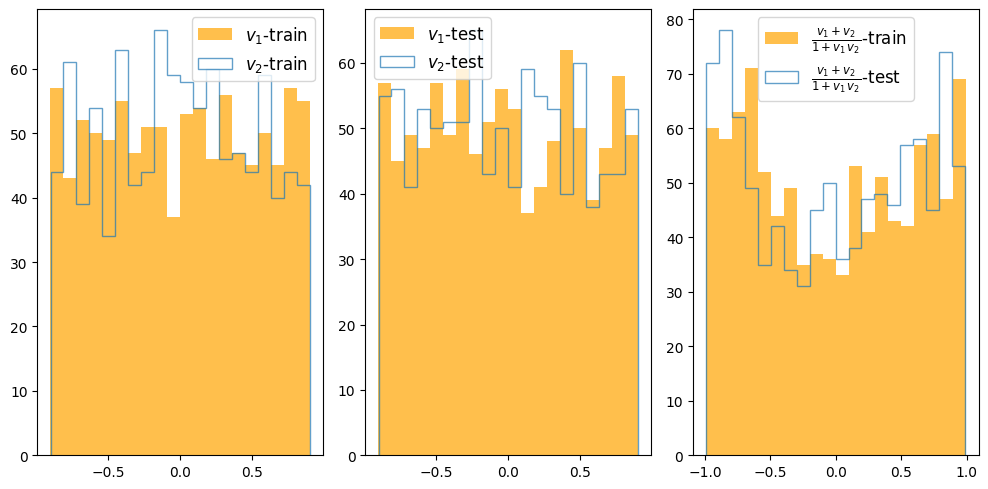

In [ ]:
f = lambda x: (x[:,[0]]+x[:,[1]])/(1+x[:,[0]]*x[:,[1]])

# dataset creation where x[:, [0]] represents v1, x[:, [1]]: v2
dataset = create_dataset(f, n_var=2, ranges=[-0.9,0.9])

#plot the distribution
### check train and test input distribution
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(131)
plt.hist(dataset['train_input'][:, 0], bins=20, alpha=0.7, label=r'$v_1$-train', color='orange')
plt.hist(dataset['train_input'][:, 1], bins=20, alpha=0.7, label=r'$v_2$-train', histtype='step')
plt.legend(fontsize=12)

fig.add_subplot(132)
plt.hist(dataset['test_input'][:, 0], bins=20, alpha=0.7, label=r'$v_1$-test', color='orange')
plt.hist(dataset['test_input'][:, 1], bins=20, alpha=0.7, label=r'$v_2$-test', histtype='step')
plt.legend(fontsize=12)

fig.add_subplot(133)
plt.hist(dataset['train_label'].numpy(), bins=20, alpha=0.7, label=r'$\frac{v_1+v_2}{1+v_1\, v_2}$-train', color='orange')
plt.hist(dataset['test_label'].numpy(), bins=20, alpha=0.7, label=r'$\frac{v_1+v_2}{1+v_1\, v_2}$-test', histtype='step')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Dataset Normalization
This is done to be checked in the experiments the impact of input values range on training stablity and final results of the model.

In [ ]:
# Assuming dataset['train_input'] is a tensor of training data
x_data = dataset['train_input'].float()  # Ensure data is float
y_data = dataset['train_label'].float()

# Calculate mean and standard deviation
x_mean = x_data.mean(dim=0)  # Mean across batch dimension
x_std = x_data.std(dim=0)  # Standard deviation across batch dimension
y_mean = y_data.mean(dim=0)  # Mean across batch dimension
y_std = y_data.std(dim=0)  # Standard deviation across batch dimension

print(f"Mean of the input train dataset: {x_mean}")
print(f"Standard Deviation of the input train dataset: {x_std}")
print(f"Mean of the label train dataset: {y_mean}")
print(f"Standard Deviation of the label train dataset: {y_std}")

Mean of the input train dataset: tensor([ 0.0018, -0.0108])
Standard Deviation of the input train dataset: tensor([0.5857, 0.5600])
Mean of the label train dataset: tensor([-0.0148])
Standard Deviation of the label train dataset: tensor([0.6800])


In [ ]:
def normalize(data, mean, std):
    """
    Normalize the data using the given mean and standard deviation.

    :param data: torch.Tensor, the data to normalize
    :param mean: torch.Tensor, the mean value(s) of the training data
    :param std: torch.Tensor, the standard deviation(s) of the training data
    :return: torch.Tensor, normalized data
    """
    return (data - mean) / std

# Example of normalizing the train and test data
normalized_x_train_data = normalize(dataset['train_input'].float(), x_mean, x_std)
normalized_y_train_data = normalize(dataset['train_label'].float(), y_mean, y_std)
normalized_x_test_data = normalize(dataset['test_input'].float(), x_mean, x_std)
normalized_y_test_data = normalize(dataset['test_label'].float(), y_mean, y_std)

print(f'{normalized_x_train_data.shape=}')
print(f'{normalized_y_train_data.shape=}')
print(f'{normalized_x_test_data.shape=}')
print(f'{normalized_y_test_data.shape=}')


# Now you can use normalized_train_data and normalized_test_data for training and testing

normalized_x_train_data.shape=torch.Size([1000, 2])
normalized_y_train_data.shape=torch.Size([1000, 1])
normalized_x_test_data.shape=torch.Size([1000, 2])
normalized_y_test_data.shape=torch.Size([1000, 1])


In [ ]:
normalized_dataset = {
    'train_input': normalized_x_train_data,
    'train_label': normalized_y_train_data,
    'test_input': normalized_x_test_data,
    'test_label': normalized_y_test_data,
}

## KAN

In our experiments, we carefully structured the model and its parameters to optimize the learning and analysis of activation functions:

- **Input and Output Configuration**:
  - **Input Features**: We have utilized 2 input features.
  - **Output Value**: The model predicts 1 output value.
  - **Hidden Nodes**: There are 5 hidden nodes used for intermediate computations in the model.

- **Grid Resolution**:
  - A grid with resolution options selected from the set $\{3, 10, 100 \}$ was employed.
  - This parameter is crucial as it determines the resolution of the reconstruction of learnable activation functions.
  - Lower values in this grid setting result in smoother activation functions.
  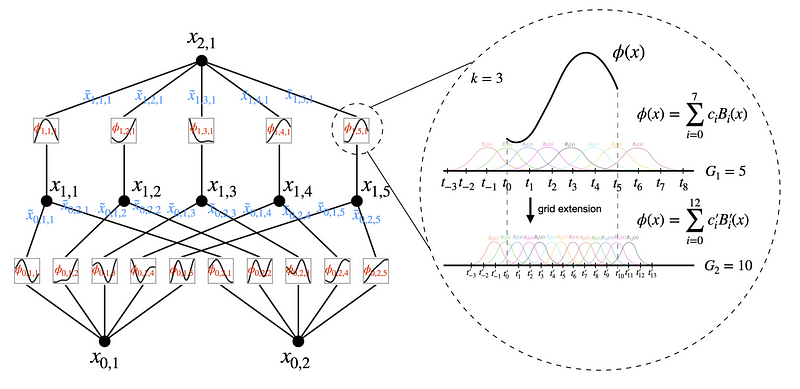

- **Activation Function Construction**:
  - The final activation function is derived from trainable coefficients of basis functions.

- **Complexity of Basis Functions**:
  - The parameter $ k $ determines the degree of the polynomial for the basis functions.
  - An increase in $ k $ allows each basis function to capture more complex relations within the data.
  - $ k = 0$
  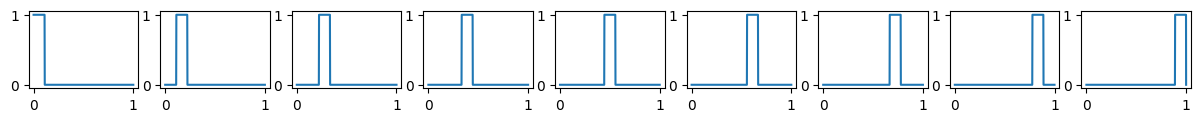
  - $ k = 1$
  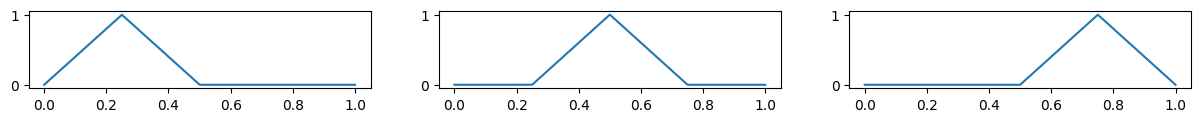
  - $ k = 2 $
  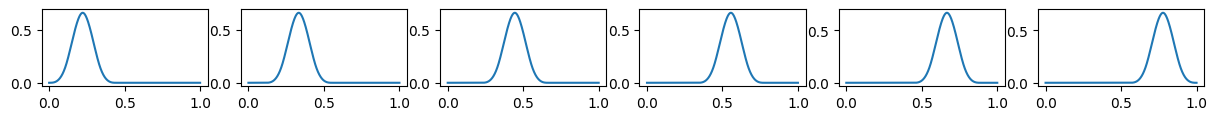

These configurations and parameters are key in shaping the behavior and performance of the model, particularly in how it learns and represents activation functions based on the input data.

In [ ]:
### let’s try this explicitly anyway
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = create_dataset(f, n_var=2,device=device)

**Note**: In the visualizations, transparency is directly related to the magnitude of the activation weights. A more transparent activation indicates a lower weight. This visual cue helps to easily distinguish between activations of different strengths.

### Original Dataset

train loss: 4.81e-02 | test loss: 5.35e-02 | reg: 3.59e+01 : 100%|█| 1000/1000 [00:55<00:00, 18.12it


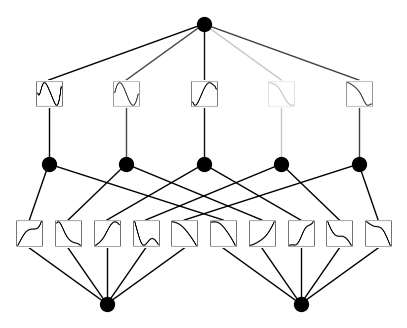

In [ ]:
model = KAN(width=[2, 5, 1], grid=3, k=3, seed=0, device=device)
model.train(dataset, opt="Adam", steps=1000, device=device)
model.plot(beta=10)

train loss: 3.03e-02 | test loss: 3.83e-02 | reg: 8.36e+01 : 100%|█| 1000/1000 [00:56<00:00, 17.70it


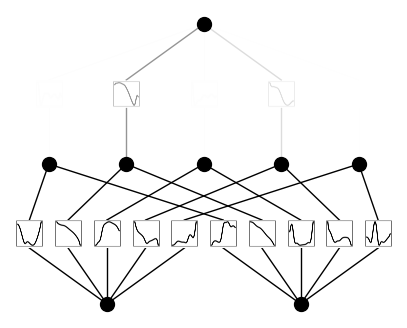

In [ ]:
model = KAN(width=[2, 5, 1], grid=10, k=3, seed=0, device=device)
model.train(dataset, opt="Adam", steps=1000, device=device)
model.plot(beta=10)

train loss: 5.60e-02 | test loss: 5.56e-02 | reg: 2.96e+01 : 100%|█| 1000/1000 [01:38<00:00, 10.11it


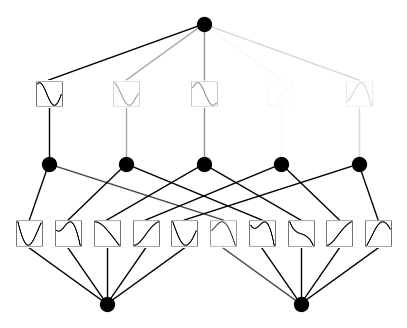

In [ ]:
model = KAN(width=[2, 5, 1], grid=3, k=10, seed=0, device=device)
model.train(dataset, opt="Adam", steps=1000, device=device)
model.plot(beta=10)

train loss: 4.11e-02 | test loss: 7.45e-02 | reg: 1.21e+02 : 100%|█| 1000/1000 [01:05<00:00, 15.20it


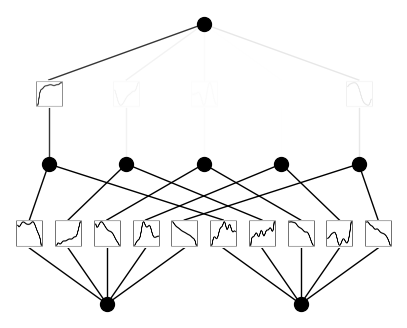

In [ ]:
model = KAN(width=[2, 5, 1], grid=10, k=10, seed=0, device=device)
model.train(dataset, opt="Adam", steps=1000, device=device)
model.plot(beta=10)

train loss: 3.68e-03 | test loss: 1.30e-01 | reg: 1.65e+01 : 100%|█| 1000/1000 [07:07<00:00,  2.34it


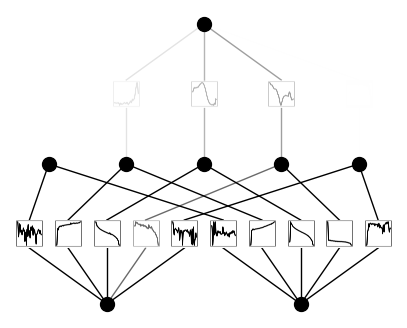

In [ ]:
model = KAN(width=[2, 5, 1], grid=100, k=10, seed=0, device=device)
model.train(dataset, opt="Adam", steps=1000, device=device)
model.plot(beta=10)

### Normalized Dataset

train loss: 5.81e-02 | test loss: 5.86e-02 | reg: 1.48e+01 : 100%|█| 1000/1000 [00:44<00:00, 22.52it


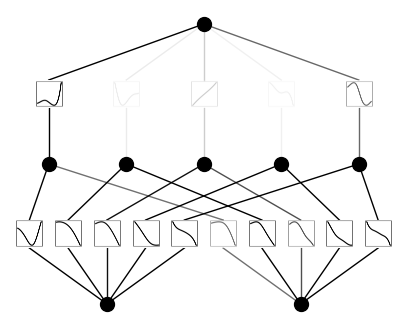

In [ ]:
model_norm = KAN(width=[2, 5, 1], grid=3, k=3, seed=0, device=device)
model_norm.train(normalized_dataset, opt="Adam", steps=1000, device=device)
model_norm.plot(beta=10)

train loss: 2.65e-02 | test loss: 3.44e-02 | reg: 3.33e+01 : 100%|█| 1000/1000 [00:56<00:00, 17.72it


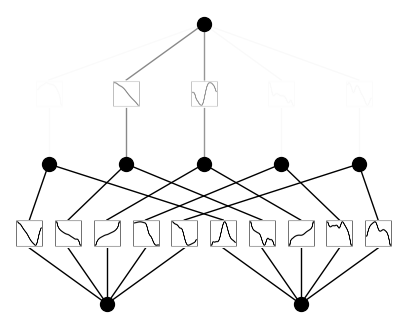

In [ ]:
model_norm = KAN(width=[2, 5, 1], grid=10, k=3, seed=0, device=device)
model_norm.train(normalized_dataset, opt="Adam", steps=1000, device=device)
model_norm.plot(beta=10)

train loss: 1.27e-01 | test loss: 1.86e-01 | reg: 3.19e+01 : 100%|█| 1000/1000 [01:32<00:00, 10.84it


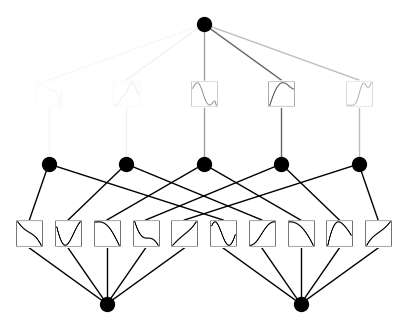

In [ ]:
model_norm = KAN(width=[2, 5, 1], grid=3, k=10, seed=0, device=device)
model_norm.train(normalized_dataset, opt="Adam", steps=1000, device=device)
model_norm.plot(beta=10)

train loss: 1.76e-02 | test loss: 3.43e-02 | reg: 2.67e+01 : 100%|█| 1000/1000 [01:52<00:00,  8.90it


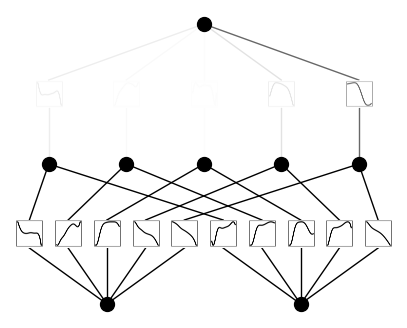

In [ ]:
model_norm = KAN(width=[2, 5, 1], grid=10, k=10, seed=0, device=device)
model_norm.train(normalized_dataset, opt="Adam", steps=1000, device=device)
model_norm.plot(beta=10)

train loss: 1.33e-02 | test loss: 6.98e-02 | reg: 1.40e+01 : 100%|█| 1000/1000 [07:05<00:00,  2.35it


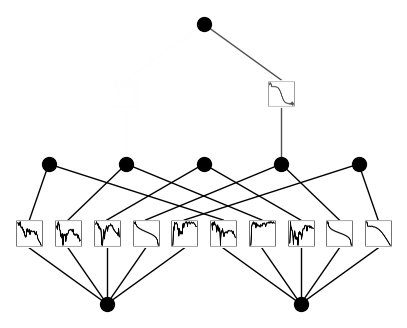

In [ ]:
model_norm = KAN(width=[2, 5, 1], grid=100, k=10, seed=0, device=device)
model_norm.train(normalized_dataset, opt="Adam", steps=1000, device=device)
model_norm.plot(beta=10)

## MLP
We designed an MLP that is equivalent to the analyzed KAN, utilizing a network architecture consisting of layers configured as [2, 5, 1]. This setup includes an intermediate layer using the ReLU activation function to facilitate non-linear processing between the input and output layers.

### Original Dataset

#### Training Phase

In [ ]:
model_mlp = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(5, 1)
)

optim = torch.optim.Adam(model_mlp.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()

# Number of epochs to train the model
num_epochs = 1000

for epoch in range(num_epochs):
    # Using tqdm to show the progress bar
    with tqdm(total=len(dataset['train_input']), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        # Ensure your data and labels are of type float and reshaped as necessary
        x_train, y_train = dataset['train_input'], dataset['train_label']

        # Forward pass: compute the model output
        y_pred = model_mlp(x_train.float())

        # Compute the loss
        loss = criterion(y_pred, y_train.float())

        # Zero gradients before running the backward pass.
        optim.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optim.step()

        # Update tqdm bar
        pbar.set_postfix({'loss': loss.item()})
        pbar.update(x_train.shape[0])  # Update the progress bar by the batch size or number of samples processed

print("Training complete.")

Epoch 1000/1000: 100%|██████████| 1000/1000 [00:00<00:00, 281289.25batch/s, loss=0.0141]

Training complete.


#### Test Phase

In [ ]:
# Retrieve the test data from the dataset
x_test, y_test = dataset['test_input'], dataset['test_label']

# Set the model to evaluation mode
model_mlp.eval()

# Initialize a list to save predictions for further evaluation, if necessary
predictions = []

# To ensure no gradients are computed in the forward pass
with torch.no_grad():
    for i in range(len(x_test)):
        # Get a single test sample and label
        x_single = x_test[i].float().unsqueeze(0)  # Add batch dimension if model expects it
        y_single = y_test[i].float().unsqueeze(0)

        # Forward pass to get the model's prediction
        y_pred = model_mlp(x_single)

        # Store predictions - optionally, for further analysis
        predictions.append(y_pred.item())

# Optionally, calculate the overall test loss if it's relevant
criterion = lambda x, y: torch.mean((x - y) ** 2)
test_loss = criterion(torch.tensor(predictions).squeeze(), y_test.float().squeeze())
print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0123


#### Learned Weights Visualization
The Python script provided visualizes the weights of each layer in a trained Multi-Layer Perceptron (MLP) using PyTorch and Matplotlib. It begins by importing necessary libraries for model handling and visualization, then identifies all linear layers in the model by filtering `torch.nn.Linear` instances. For each layer, it extracts the weights, converts them into a NumPy array, and plots them using Matplotlib's `imshow` function. This function displays the weight matrix as an image where each weight's value affects the pixel's color intensity, using a grayscale color map to denote different weight magnitudes.

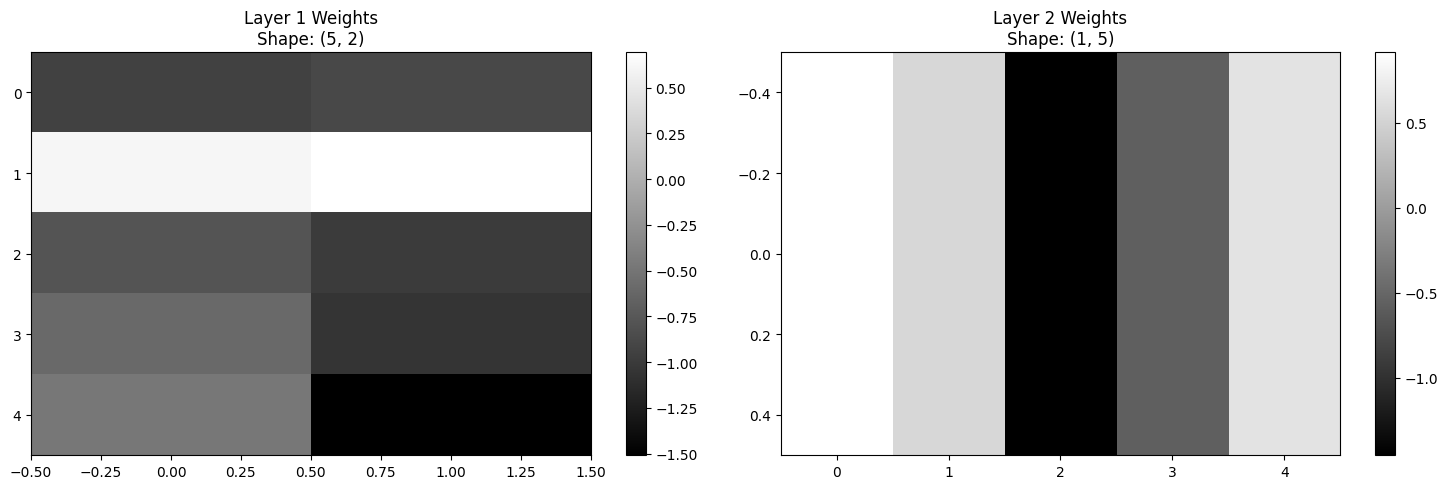

In [ ]:
# Assuming model_mlp is your trained model
# Extracting the weights from the model
layers = [module for module in model_mlp.modules() if isinstance(module, torch.nn.Linear)]

# Set up matplotlib figure and axes
fig, axs = plt.subplots(1, len(layers), figsize=(15, 5))

# Plotting the weights of each layer
for i, layer in enumerate(layers):
    weights = layer.weight.data.numpy()  # Convert weights to numpy array for easy handling
    ax = axs[i] if len(layers) > 1 else axs
    im = ax.imshow(weights, aspect='auto', interpolation='none', cmap='gray')
    ax.set_title(f'Layer {i+1} Weights\nShape: {weights.shape}')
    fig.colorbar(im, ax=ax)  # Add a colorbar to each subplot

plt.tight_layout()
plt.show()


### Normalized Dataset

#### Training Phase

In [ ]:
from tqdm import tqdm

model_mlp = torch.nn.Sequential(
    torch.nn.Linear(2, 5),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(5, 1)
)

optim = torch.optim.Adam(model_mlp.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()

# Number of epochs to train the model
num_epochs = 1000

for epoch in range(num_epochs):
    # Using tqdm to show the progress bar
    with tqdm(total=len(normalized_dataset['train_input']), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        # Ensure your data and labels are of type float and reshaped as necessary
        x_train, y_train = normalized_dataset['train_input'], normalized_dataset['train_label']

        # Forward pass: compute the model output
        y_pred = model_mlp(x_train.float())

        # Compute the loss
        loss = criterion(y_pred, y_train.float())

        # Zero gradients before running the backward pass.
        optim.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optim.step()

        # Update tqdm bar
        pbar.set_postfix({'loss': loss.item()})
        pbar.update(x_train.shape[0])  # Update the progress bar by the batch size or number of samples processed

print("Training complete.")

Epoch 1000/1000: 100%|██████████| 1000/1000 [00:00<00:00, 287813.35batch/s, loss=0.0421]

Training complete.


#### Test Phase

In [ ]:
# Retrieve the test data from the dataset
x_test, y_test = normalized_dataset['test_input'], normalized_dataset['test_label']

# Set the model to evaluation mode
model_mlp.eval()

# Initialize a list to save predictions for further evaluation, if necessary
predictions = []

# To ensure no gradients are computed in the forward pass
with torch.no_grad():
    for i in range(len(x_test)):
        # Get a single test sample and label
        x_single = x_test[i].float().unsqueeze(0)  # Add batch dimension if model expects it
        y_single = y_test[i].float().unsqueeze(0)

        # Forward pass to get the model's prediction
        y_pred = model_mlp(x_single)

        # Store predictions - optionally, for further analysis
        predictions.append(y_pred.item())

# Optionally, calculate the overall test loss if it's relevant
criterion = lambda x, y: torch.mean((x - y) ** 2)
print(f'{torch.tensor(predictions).shape=}')
print(f'{y_test.shape=}')
test_loss = criterion(torch.tensor(predictions).squeeze(), y_test.float().squeeze())
print(f'Test Loss: {test_loss.item():.4f}')

torch.tensor(predictions).shape=torch.Size([1000])
y_test.shape=torch.Size([1000, 1])
Test Loss: 0.0401


#### Learned Weights Visualization
The Python script provided visualizes the weights of each layer in a trained Multi-Layer Perceptron (MLP) using PyTorch and Matplotlib. It begins by importing necessary libraries for model handling and visualization, then identifies all linear layers in the model by filtering `torch.nn.Linear` instances. For each layer, it extracts the weights, converts them into a NumPy array, and plots them using Matplotlib's `imshow` function. This function displays the weight matrix as an image where each weight's value affects the pixel's color intensity, using a grayscale color map to denote different weight magnitudes.

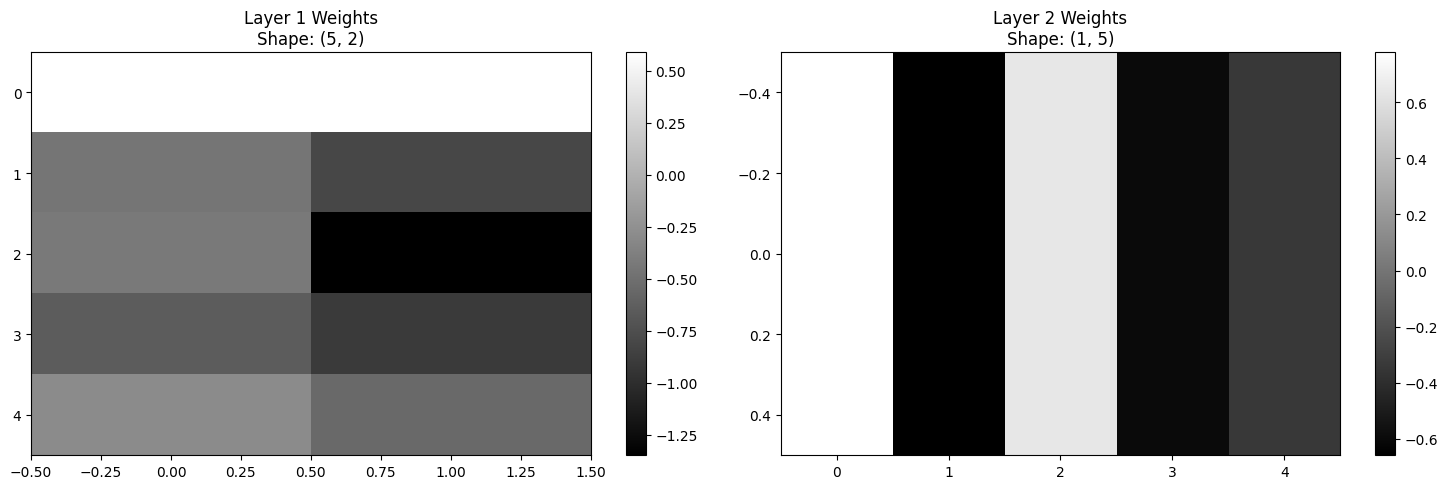

In [ ]:
# Assuming model_mlp is your trained model
# Extracting the weights from the model
layers = [module for module in model_mlp.modules() if isinstance(module, torch.nn.Linear)]

# Set up matplotlib figure and axes
fig, axs = plt.subplots(1, len(layers), figsize=(15, 5))

# Plotting the weights of each layer
for i, layer in enumerate(layers):
    weights = layer.weight.data.numpy()  # Convert weights to numpy array for easy handling
    ax = axs[i] if len(layers) > 1 else axs
    im = ax.imshow(weights, aspect='auto', interpolation='none', cmap='gray')
    ax.set_title(f'Layer {i+1} Weights\nShape: {weights.shape}')
    fig.colorbar(im, ax=ax)  # Add a colorbar to each subplot

plt.tight_layout()
plt.show()
